# Machine Learning

## Import dependencies


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

import seaborn as sns

## Read data

In [5]:
def read_train_test_data():
    """Returns: X_train, X_test, X_val, y_train, y_test, y_val"""
    
    X_train = pd.read_csv("../data/train_test_val/X_train.csv", 
                          header=[0], index_col=0).reset_index(drop=True)
    X_test = pd.read_csv("../data/train_test_val/X_test.csv", 
                         header=[0], index_col=0).reset_index(drop=True)
    X_val = pd.read_csv("../data/train_test_val/X_val.csv", 
                        header=[0], index_col=0).reset_index(drop=True)
    
    X_train = X_train.drop(["measurementID","id_gps"], axis=1)
    X_val = X_val.drop(["measurementID","id_gps"], axis=1)
    X_test = X_test.drop(["measurementID","id_gps"], axis=1)

    y_train = pd.read_csv("../data/train_test_val/y_train.csv", index_col=0)\
        .reset_index(drop=True).values.reshape(-1)
    y_val = pd.read_csv("../data/train_test_val/y_val.csv", index_col = 0)\
        .reset_index(drop=True).values.reshape(-1)
    y_test = pd.read_csv("../data/train_test_val/y_test.csv", index_col = 0)\
        .reset_index(drop=True).values.reshape(-1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

### Creating ML Pipeline

In [6]:
def define_models():
    
    rfc = RandomForestClassifier(random_state=42)
    svc = SVC(random_state=42)
    knc = KNeighborsClassifier()
    abc = AdaBoostClassifier(random_state=42)
    gbc = GradientBoostingClassifier(random_state=42)
    gnb = GaussianNB()
    # lr = LogisticRegressionCV(max_iter=500, random_state=42)

    models = {"rfc": rfc,"svc": svc, "knc" : knc,
              "abc" : abc, "gbc" : gbc, "gnb" :gnb}
    
    return models

In [45]:
def train_models(scaler = False):
    
    X_train, X_test, X_val, y_train, y_test, y_val = read_train_test_data()
    
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train) 
    scaled_X_val = scaler.fit_transform(X_val)
    scaled_X_test = scaler.fit_transform(X_test)

    if scaler:
        X_train = scaled_X_train
        X_val = scaled_X_val
        X_test = scaled_X_test 
        
        
        
    result = {"model" : [],
             "accuracy" : [],
             "precision" : [],
             "recall" : [],
             "cross_val_min" : [],
             "cross_val_max" : [],
             "cross_val_delta" : []}
    
    models = define_models()

    for m in models:

        model = models[m].fit(X_train, y_train)
        preds = model.predict(X_val)

        accuracy = accuracy_score(y_val,preds)
        precision = precision_score(y_val,preds,average="weighted")
        recall = recall_score(y_val,preds, average="weighted")
        f1 = f1_score(y_val, preds, average="weighted")

#         print("Metrics on Validation Dataset:")
#         print("\n")

#         print(f"Accuracy {m}: {accuracy}")
#         print(f"Precision {m}: {precision}")
#         print(f"Recall {m}: {recall}")
#         print(f"F1 Score {m}: {f1}")

#         print("\n")
#         print("Cross Validation on Test Dataset:")
#         print("\n")
        cv = cross_validate(model,
                            X =  X_test,
                            y = np.ravel(y_test),
                            cv = 10)

#         print("{} accuracy is {:.2f}±{:.2f}".format(m,cv["test_score"].mean()*100,cv["test_score"].std()*100))


#         print("\n")
#         print("Test Scores:\n min: {}\n max: {}\n delta: {}"\
#               .format(cv["test_score"].min(), 
#                       cv["test_score"].max(),
#                       cv["test_score"].max()-cv["test_score"].min()))
#         print("\n")
#         print("*"*20)
#         print("\n")

        cm = confusion_matrix(y_val,preds)

        fig = plt.figure()
        fig = plt.title(m)
        sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)
        
        result["model"].append(m)
        result["accuracy"].append(accuracy)
        result["precision"].append(precision)
        result["recall"].append(recall)
        result["cross_val_min"].append(cv["test_score"].min())
        result["cross_val_max"].append(cv["test_score"].max())
        result["cross_val_delta"].append(cv["test_score"].max()-cv["test_score"].min())
        
    summary = pd.DataFrame(result)
    
    return summary
        

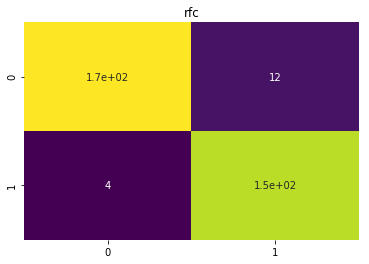

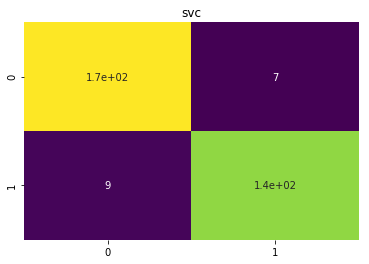

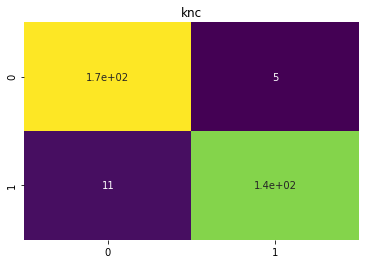

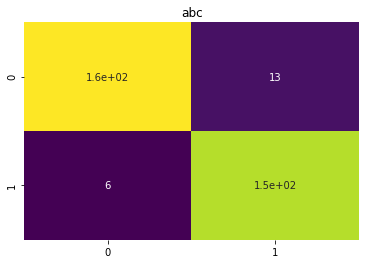

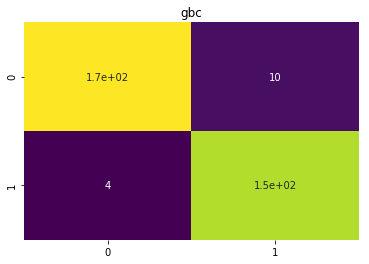

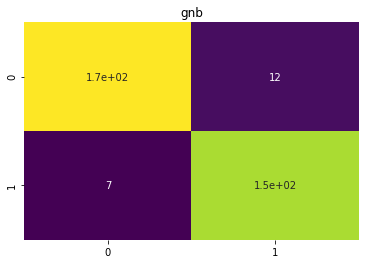

In [46]:
summary = train_models()

In [47]:
summary

,model,accuracy,precision,recall,cross_val_min,cross_val_max,cross_val_delta
0,rfc,0.951662,0.952894,0.951662,0.826087,1.0,0.173913
1,svc,0.951662,0.951684,0.951662,0.869565,1.0,0.130435
2,knc,0.951662,0.952129,0.951662,0.739130,1.0,0.260870
3,abc,0.942598,0.943574,0.942598,0.869565,1.0,0.130435
4,gbc,0.957704,0.958422,0.957704,0.869565,1.0,0.130435
5,gnb,0.942598,0.943134,0.942598,0.826087,1.0,0.173913


## Hyperparameter tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Cross Validation

In [11]:
X_train, X_test, X_val, y_train, y_test, y_val = read_train_test_data()

In [16]:
svc = SVC(random_state=42)
svc.fit(X_train,train)
preds = svc.predict(X_test)

In [34]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)

In [35]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [36]:
cv = cross_validate(svc,
               X =  scaled_X_test,
               y = np.ravel(y_test),
                   cv = 10)

print("Model accuracy is {:.2f}±{:.2f}".format(cv["test_score"].mean()*100,cv["test_score"].std()*100))
print(cv)

Model accuracy is 93.50±4.02
{'fit_time': array([0.00699568, 0.00699663, 0.00599551, 0.00699639, 0.00599623,
       0.00699306, 0.00699806, 0.00599432, 0.00799632, 0.00599575]), 'score_time': array([0.0010004 , 0.00099945, 0.00099802, 0.0010004 , 0.0009985 ,
       0.00100088, 0.00199723, 0.00099969, 0.00099945, 0.00300097]), 'test_score': array([0.95833333, 0.95652174, 0.86956522, 0.91304348, 0.86956522,
       0.95652174, 0.91304348, 0.95652174, 0.95652174, 1.        ])}


In [37]:
cm = confusion_matrix(y_test,preds)

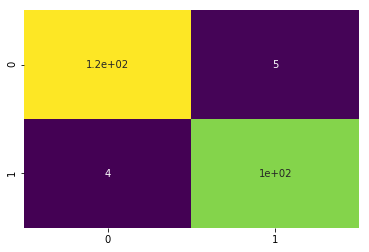

In [38]:
sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

## Save the model

In [16]:
from joblib import dump, load
dump(rfc, '../models/rfc_v14.joblib') 

['../models/rfc_v14.joblib']

# Evaluate


In [18]:
from processing_funcs import *
from scipy.stats import norm, kurtosis
from scipy import signal
import glob

In [19]:
df = read_all(1/50)

ok = df[df["label"] == 0]
nok = df[df["label"] == 1]

In [353]:
test = read_measurement("../data/raw_data_train/test/*", 1/50)

In [39]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', "z_lin_acc", 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["measurementID","id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})
    
    new_cols = []
    
    for k,i in enumerate(agg_df.columns):
        
        new_cols.append(i[0] + "_" +  i[1])

    agg_df.columns = new_cols
    
    return agg_df

In [40]:
feature_df = create_aggregated(ok).reset_index()

In [22]:
scaler = StandardScaler()
scaled = scaler.fit_transform(feature_df.drop(["measurementID", "id_gps"],axis = 1))

In [42]:
#scaled
# pred = rfc.predict(scaled)
# not scaled
pred = rfc.predict(feature_df.drop(["measurementID", "id_gps"], axis = 1))

In [43]:
map_df = pd.concat([ok[["measurementID", "id_gps", "lat", "lon"]]\
                    .groupby(["measurementID","id_gps"])\
                    .max()\
                    .reset_index(), 
                    pd.DataFrame({"label" : pred})], axis=1)

In [44]:
fig = go.Figure()
fig = px.scatter_mapbox(map_df, 
                        lat="lat", 
                        lon="lon",
                        zoom = 11, 
                        height=500, 
                        color = "label", 
                        color_continuous_scale=["green","red"])
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.layout.coloraxis.showscale = False
fig